In [2]:
# %load startup_script.py

# numerical & stats 
import pandas as pd
import numpy as np
from scipy import stats

# plotting
from matplotlib import pyplot as plt

# machine learning
from sklearn import linear_model

# jupyte notebook amenities
%matplotlib inline
%autosave 10

Autosaving every 10 seconds


In [11]:
WCDT_mRNA = "./data/WCDT_mRNA.tsv"
WCDT_clinical = "./data/WCDT_clinical.tsv"

In [12]:
# small cell v.s. not small cell

def data_prep1():
    df_mRNA = pd.read_csv(WCDT_mRNA, delimiter="\t")
    df_clinical = pd.read_csv(WCDT_clinical, delimiter="\t")
    
    #extract y label
    y = df_clinical[["Patient ID", "Classification #3"]].copy()
    y = y[y["Classification #3"]!="Exclude"]
    y.set_index("Patient ID", inplace=True)
    y[y["Classification #3"].isin(["Small cell", "Small Cell"])] = 1
    y[y["Classification #3"].isin(["Not small cell", "Not-small cell"])] = 0
    y.index.rename("patient_id", inplace=True)
    y.rename(columns={"Classification #3":"NEPC_label"}, inplace=True)
    
    # get sample overlap between WCDT mRNA and WCDT clinical
    df_mRNA.set_index("gene_id", inplace=True)
    X = df_mRNA.transpose()
    X.index.rename("patient_id", inplace=True)
    overlap = set(X.index).intersection(set(y.index))
    y = y[y.index.isin(overlap)]
    X = X[X.index.isin(overlap)]
    
    # order X and Y so that same sample name match up
    X.sort_index(inplace=True)
    y.sort_index(inplace=True)
    assert(list(X.index) == list(y.index))
    
    
    return X, y


X, y = data_prep1()
classifiers = {#"Enet": linear_model.ElasticNet(alpha=0.1, l1_ratio=0.001),
               "Logistic Regression": linear_model.LogisticRegression(), 
               #"Lasso": linear_model.Lasso(alpha=0.01), 
               #"Ridge Regression": linear_model.Ridge(),
               #"KernelRidge": kernel_ridge.KernelRidge()
              }

for classifier_name, classifier in classifiers.items():
    classifier.fit(X, np.array(list(y['NEPC_label'])))
    print(classifier.coef_)

[[  5.62949616e-03  -2.92058734e-03   5.87813146e-04 ...,  -9.67582040e-04
    8.88064571e-06   2.26914213e-04]]


19709
18761
union 19709
intersection 16680


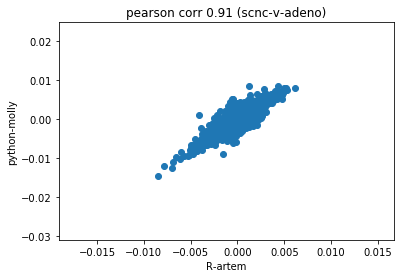

In [18]:
# small cell v.s. adeno

def data_prep2():
    df_mRNA = pd.read_csv(WCDT_mRNA, delimiter="\t")
    df_clinical = pd.read_csv(WCDT_clinical, delimiter="\t")
    
    #extract y label    
    y = df_clinical[["Patient ID", "Classification #1"]].copy()
    y = y[~y["Classification #1"].isin(["Exclude", "IAC"])]


    y.set_index("Patient ID", inplace=True)
    
    y[y["Classification #1"].isin(["Small cell", "Small Cell"])] = 1
    y[y["Classification #1"].isin(["Adeno", "Adenocarcinoma"])] = 0
    y.index.rename("patient_id", inplace=True)
    y.rename(columns={"Classification #1":"NEPC_label"}, inplace=True)    
    
    # get sample overlap between WCDT mRNA and WCDT clinical
    X = df_mRNA.set_index("gene_id")
    X = X.transpose()
    overlap = set(X.index).intersection(set(y.index))
    y = y[y.index.isin(overlap)]
    X = X[X.index.isin(overlap)]
    
    # order X and Y so that same sample name match up
    X.sort_index(inplace=True)
    y.sort_index(inplace=True)
    assert(list(X.index) == list(y.index))
    
    return X, y

X, y = data_prep2()
classifiers = {#"Enet": linear_model.ElasticNet(alpha=0.1, l1_ratio=0.001),
               "Logistic Regression": linear_model.LogisticRegression(), 
               #"Lasso": linear_model.Lasso(alpha=0.01), 
               #"Ridge Regression": linear_model.Ridge(),
               #"KernelRidge": kernel_ridge.KernelRidge()
              }

for classifier_name, classifier in classifiers.items():
    classifier.fit(X, np.array(list(y['NEPC_label'])))
    scnc_v_adeno = classifier.coef_[0]
scnc_v_adeno_dict = dict(zip(X.columns, scnc_v_adeno))

sigs = pd.read_csv("data/NEPC/scnc-v-adeno-20k-sig.rnk", 
                         delimiter="\t", names=["gene","artem"], index_col=0)

print(len(sigs.index))
print(len(scnc_v_adeno))

for gene, py_score in scnc_v_adeno_dict.items():
    if gene in sigs.index:
        sigs.set_value(gene, "python", py_score)
        
print("union", len(sigs.index))
        
sigs.dropna(inplace=True)

print("intersection", len(sigs.index))


plt.scatter(sigs["artem"], sigs["python"])
plt.title("pearson corr %.2f (scnc-v-adeno)" %stats.pearsonr(sigs["artem"], sigs["python"])[0])
plt.xlabel("R-artem")
plt.ylabel("python-molly")

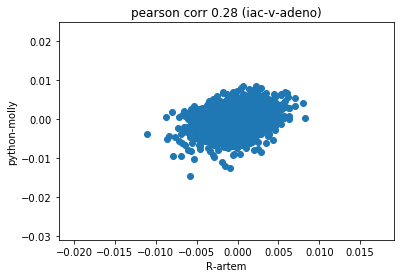

In [14]:
# IAC v.s. adeno

def data_prep2():
    df_mRNA = pd.read_csv(WCDT_mRNA, delimiter="\t")
    df_clinical = pd.read_csv(WCDT_clinical, delimiter="\t")
    
    #extract y label    
    y = df_clinical[["Patient ID", "Classification #1"]].copy()
    y = y[~y["Classification #1"].isin(["Exclude", "Small cell", "Small Cell"])]


    y.set_index("Patient ID", inplace=True)
    
    y[y["Classification #1"].isin(["IAC"])] = 1
    y[y["Classification #1"].isin(["Adeno", "Adenocarcinoma"])] = 0
    y.index.rename("patient_id", inplace=True)
    y.rename(columns={"Classification #1":"NEPC_label"}, inplace=True)    
    
    # get sample overlap between WCDT mRNA and WCDT clinical
    X = df_mRNA.set_index("gene_id")
    X = X.transpose()
    overlap = set(X.index).intersection(set(y.index))
    y = y[y.index.isin(overlap)]
    X = X[X.index.isin(overlap)]
    
    # order X and Y so that same sample name match up
    X.sort_index(inplace=True)
    y.sort_index(inplace=True)
    assert(list(X.index) == list(y.index))
    
    return X, y

X, y = data_prep2()

classifiers = {#"Enet": linear_model.ElasticNet(alpha=0.1, l1_ratio=0.001),
               "Logistic Regression": linear_model.LogisticRegression(), 
               #"Lasso": linear_model.Lasso(alpha=0.01), 
               #"Ridge Regression": linear_model.Ridge(),
               #"KernelRidge": kernel_ridge.KernelRidge()
              }

for classifier_name, classifier in classifiers.items():
    classifier.fit(X, np.array(list(y['NEPC_label'])))
    iac_v_adeno = classifier.coef_[0]
iac_v_adeno_dict = dict(zip(X.columns, iac_v_adeno))

sigs = pd.read_csv("data/NEPC/iac-v-adeno-20k-sig.rnk", 
                         delimiter="\t", names=["gene","artem"], index_col=0)

for gene, py_score in scnc_v_adeno_dict.items():
    if gene in sigs.index:
        sigs.set_value(gene, "python", py_score)
sigs.dropna(inplace=True)
plt.scatter(sigs["artem"], sigs["python"])
plt.title("pearson corr %.2f (iac-v-adeno)" %stats.pearsonr(sigs["artem"], sigs["python"])[0])
plt.xlabel("R-artem")
plt.ylabel("python-molly")